## Stage Progress

The *stage progress chart* is a deltascope designd to reveal differences arising from, and associated with, a particular stage compared to the previous stage.

This notebook contains the original sketches exploring the formulation of this novel chart type.

In [28]:
year=2018
rc='RC1'
ss='SS4'
rally='Sweden'

typ='stage_times_stage' #stage_times_stage stage_times_overall
typ='stage_times_overall'

In [16]:
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
import sqlite3
dbname='wrc18.db'
conn = sqlite3.connect(dbname)


In [10]:
def samesign(a,b):
    return (a*b) >0

In [11]:
#want rebased delta if different sign else smaller
#?? if same sign, then return smaller?
def thing(overall,delta):
    if overall<0 and delta<0:
        return overall if overall>delta else delta
    elif overall>0 and delta>0:
        return overall if overall<delta else delta
    return delta
    #return min([a,b], key=abs)

#Return thing closest to zero if samesign, else delta
def thing2(overall,delta):
    if samesign(overall,delta): return min([overall,delta], key=abs)
    return delta

thing(-2,-1.5),thing(1.5,2), thing(2,1.5)

for a,b in [(-1,-0.5),(-0.5,-1),(-0.5,1),(-1,0.5),(0.5,1),(1,0.5)]:
    print(a,b, thing(a,b), thing2(a,b), thing(a,b)==thing2(a,b))

-1 -0.5 -0.5 -0.5 True
-0.5 -1 -0.5 -0.5 True
-0.5 1 1 1 True
-1 0.5 0.5 0.5 True
0.5 1 0.5 0.5 True
1 0.5 0.5 0.5 True


In [12]:
#overall is rebased diff at end of current stage; negative means target is ahead
#prev is rebased diff at end if revious stage; negative means target is ahead
#delta is rebased_curr - rebased_prev; positive means target lost ground
df=pd.DataFrame([{'name':'a','overall':11,'delta':2,'prev':9,'deltax':2},
                {'name':'b','overall':6,'delta':-2,'prev':8,'deltax':-2},
                {'name':'g','overall':8,'delta':12,'prev':-4,'deltax':8},
                {'name':'c','overall':0,'delta':0,'prev':0,'deltax':0},
                {'name':'d','overall':-6,'delta':-2,'prev':-4,'deltax':-2},
                {'name':'e','overall':-8,'delta':2,'prev':-10,'deltax':2},
                {'name':'f','overall':-8,'delta':-12,'prev':4,'deltax':-8},
                ])

df['deltaxx']=df.apply(lambda x: thing(x['overall'],x['delta']), axis=1)
df = df.set_index('name')
df
#if overall and delta have same sign, then use the one closest to 0

,delta,deltax,overall,prev,deltaxx
name,,,,,
a,2,2,11,9,2
b,-2,-2,6,8,-2
g,12,8,8,-4,8
c,0,0,0,0,0
d,-2,-2,-6,-4,-2
e,2,2,-8,-10,2
f,-12,-8,-8,4,-8


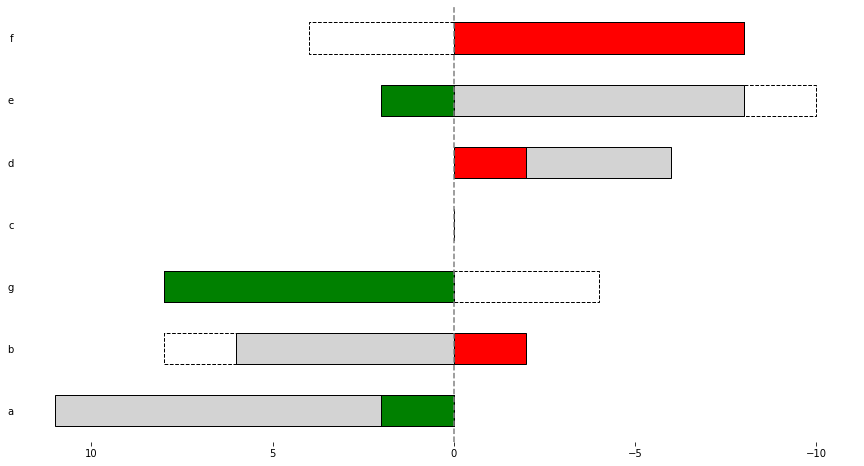

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax.yaxis.label.set_visible(False)
ax.tick_params(axis='y', which='both',length=0)

plt.axvline(x=0,linestyle='dashed',color='grey')

df['prev'].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)

df['overall'].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
df['deltaxx'].plot(kind='barh',color=['r' if x else 'g' for x in df['deltaxx']<0],edgecolor='black',ax=ax)



ax.invert_xaxis()
#Hide outer box
plt.box(on=None)

How to read the above chart:

- chart is ordered from top down, fastest overall at top;
- x-axis is time delta to other identified cars from a target car; negative bar means target is behind target car by that time;
- green colour shows the target gained time on the stage relative to the identified car, reducing any lead it has over the target, or adding to the gap behind the target;
- red colour shows time was lost on the stage by the target relative to the identified car, adding to any lead that car has over the target, or reducing the gap to a car behind the target;
- a dashed bar shows the situation at the end of the previous stage;

### Exploring Additional Colour Maps

We can use colour to highlight information in different ways. For example, if a target driver loses time to another car, should we colour that other car's delta as red, from the perspective of the target driver that this is a bad thing and we need to be warned about it, or green, as it might be displayed on a "global" timing screen to show that the other car has made time on the target car?

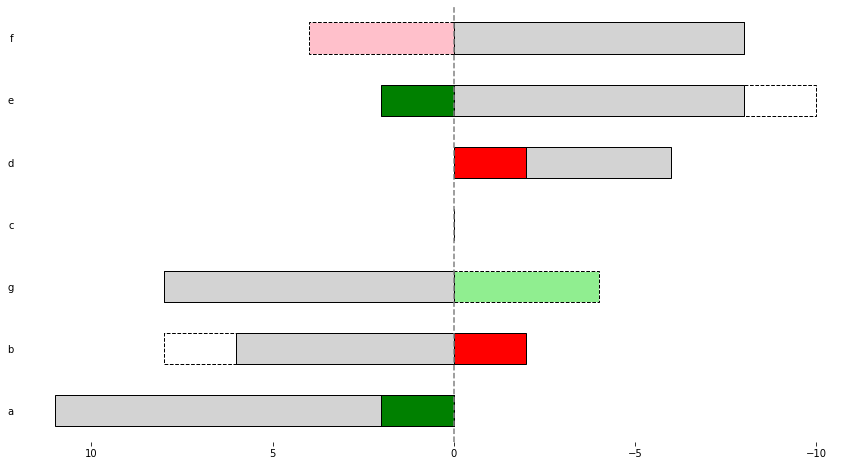

In [657]:
fig, ax = plt.subplots(figsize=(15,8))
ax.yaxis.label.set_visible(False)
ax.tick_params(axis='y', which='both',length=0)

plt.axvline(x=0,linestyle='dashed',color='grey')


#Let's start trying to figure out color maps
def colmap1(a,b):
    if a==b: return 'lightgrey'
    else: return 'r' if b<0 else 'g'
        
def colmap2(a,b):
    if not samesign(a,b): return 'w'
    else: return 'pink' if b<0 else 'lightgreen'

df['prev'].plot(kind='barh', color=df.apply(lambda x: colmap2(x['overall'],x['deltaxx']),axis=1),edgecolor='w',ax=ax)
df['prev'].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)

df['overall'].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
#df['deltaxx'].plot(kind='barh',color=['r' if x else 'g' for x in df['deltaxx']<0],edgecolor='black',ax=ax)
df['deltaxx'].plot(kind='barh',color=df.apply(lambda x: colmap1(x['overall'],x['deltaxx']),axis=1),edgecolor='black',ax=ax)


ax.invert_xaxis()
#Hide outer box
plt.box(on=None)

So what do we need for this sort of chart?

- drivercode;
- total accumulated time at end of previous stage;
- total accumulated time at end of current stage;
- rebased differences from each driver to a target driver for previous and current stage;
- delta for each driver based on rebased difference times from previous and current stages.


In [29]:
snum=4
typ='stage_times_overall'

#this represents a subset of dbGetStageRank in "Charts - Stage Results.ipynb"
#use that function instead?
def getStageResult( rally, typ, snum, rc):
    q='''
    SELECT st.totalTimeMs, sc.name as class, i.code, i.distance, i.name, CAST(REPLACE(code,'SS','') AS INTEGER) snum,
    sl.`driver.code`, sl.`entrant.name`
    FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
    INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId
    WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" AND snum={stage} ORDER BY snum
    '''.format(rc=rc,rally=rally, typ=typ, stage=snum)
    return pd.read_sql(q,conn)

curr = getStageResult( rally, typ, snum, rc)
curr['snum'] = 'curr'
prev = getStageResult( rally, typ, snum-1, rc)
prev['snum'] = 'prev'

stagerank= pd.concat([curr,prev]).reset_index(drop=True)
stagerank.head(3)

,totalTimeMs,class,code,distance,name,snum,driver.code,entrant.name
0,2149700,RC1,SS4,19.13,SS4 Röjden 1,curr,NEU,HYUNDAI SHELL MOBIS WRT
1,2153400,RC1,SS4,19.13,SS4 Röjden 1,curr,MIK,HYUNDAI SHELL MOBIS WRT
2,2155000,RC1,SS4,19.13,SS4 Röjden 1,curr,LAP,TOYOTA GAZOO RACING WRT


In [30]:
dfx = stagerank.pivot('driver.code','snum','totalTimeMs')
dfx

snum,curr,prev
driver.code,,
AL,2386400,1698800
BRE,2164700,1542800
EVA,2247400,1557600
LAP,2155000,1533600
LAT,2166700,1540800
MEE,2188400,1554500
MIK,2153400,1534900
NEU,2149700,1529300
OGI,2197400,1556900


In [31]:
drivercode = 'LAT'
#drivercode = 'PAD'

In [32]:
rebase = dfx.loc[drivercode].to_dict()
rebase

{'curr': 2166700, 'prev': 1540800}

In [33]:
#rebased_curr is rebased diff at end of current stage; negative means target is ahead
#rebased_prev is rebased diff at end if revious stage; negative means target is ahead
#rebased_delta is rebased_curr - rebased_prev; positive means target lost ground

In [34]:
dfx['rebased_curr'] = ((dfx['curr'] - rebase['curr'])/1000).round(1)
dfx['rebased_prev'] = ((dfx['prev'] - rebase['prev'])/1000).round(1)
dfx['rebased_delta'] = dfx['rebased_curr'] - dfx['rebased_prev']

dfx['deltaxx']=dfx.apply(lambda x: thing(x['rebased_curr'],x['rebased_delta']), axis=1)

dfx

snum,curr,prev,rebased_curr,rebased_prev,rebased_delta,deltaxx
driver.code,,,,,,
AL,2386400,1698800,219.7,158.0,61.7,61.7
BRE,2164700,1542800,-2.0,2.0,-4.0,-2.0
EVA,2247400,1557600,80.7,16.8,63.9,63.9
LAP,2155000,1533600,-11.7,-7.2,-4.5,-4.5
LAT,2166700,1540800,0.0,0.0,0.0,0.0
MEE,2188400,1554500,21.7,13.7,8.0,8.0
MIK,2153400,1534900,-13.3,-5.9,-7.4,-7.4
NEU,2149700,1529300,-17.0,-11.5,-5.5,-5.5
OGI,2197400,1556900,30.7,16.1,14.6,14.6


### Make a function of the original stage progress chart

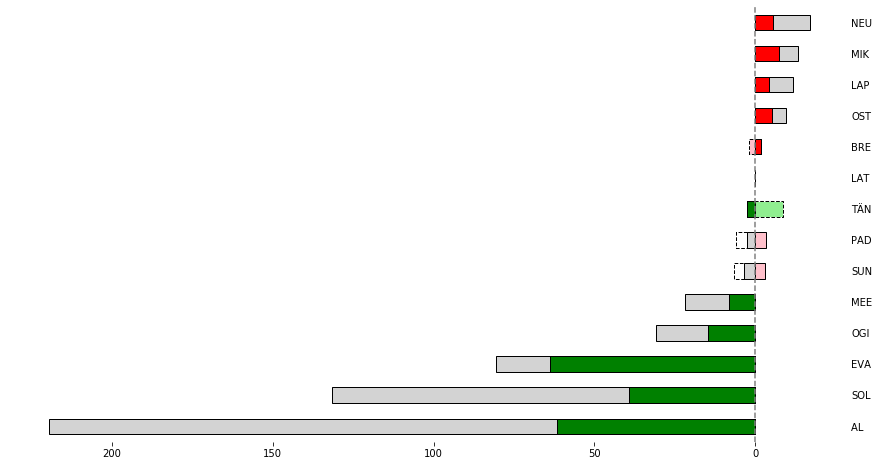

In [35]:
def stageProgessBarOrig(df,prev,curr,delta,deltaxx,title=None):
    df = df.sort_values(curr,ascending=False)
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.yaxis.label.set_visible(False)
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both',length=0)

    plt.axvline(x=0,linestyle='dashed',color='grey')

    
    #Thre previous colour maps weren't quite correct
    def colmap3(row):
        if not samesign(row[deltaxx], row[curr]): return 'w'
        return 'pink' if row[curr]<row[prev] else 'lightgreen'

    def colmap4(row):
        #if not samesign(row[delta], row[deltaxx]): return 'lightgrey'    
        if not samesign(row[curr],row[delta]):
            return 'pink' if (row[deltaxx]<0) else 'lightgreen'
        return 'r' if (row[deltaxx]<0) else 'g'

    df[prev].plot(kind='barh', color=df.apply(lambda x: colmap3(x),axis=1),edgecolor='w',ax=ax)
    df[prev].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)
    #df[prev].plot(kind='barh',edgecolor='black', fill=False, ax=ax)
    df[curr].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
    
    df[deltaxx].plot(kind='barh',color=df.apply(lambda x: colmap4(x),axis=1),edgecolor='black',ax=ax)
    

    ax.invert_xaxis()
    #Hide outer box
    plt.box(on=None)
    if title: plt.title(title)

#MEE needs to be pink,
stageProgessBarOrig(dfx,'rebased_prev','rebased_curr','rebased_delta','deltaxx')

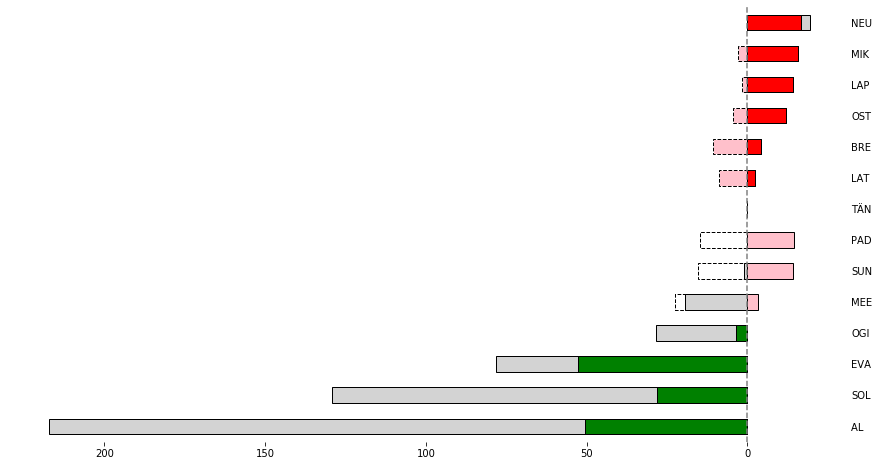

In [36]:
snum=4
typ='stage_times_overall'

#this represents a subset of dbGetStageRank in "Charts - Stage Results.ipynb"
#use that function instead?
def getStageResult( rally, typ, snum, rc):
    q='''
    SELECT st.totalTimeMs, sc.name as class, i.code, i.distance, i.name, CAST(REPLACE(code,'SS','') AS INTEGER) snum,
    sl.`driver.code`, sl.`entrant.name`
    FROM {typ} st INNER JOIN itinerary_stages i ON st.stageId = i.stageId
    INNER JOIN startlist_classes sc ON sc.entryid = st.entryId 
    INNER JOIN championship_events ce ON i.eventId=ce.eventId
    INNER JOIN startlists sl ON sl.entryId=sc.entryId
    WHERE sc.name="{rc}" AND ce.`country.name`="{rally}" AND snum={stage} ORDER BY snum
    '''.format(rc=rc,rally=rally, typ=typ, stage=snum)
    return pd.read_sql(q,conn)

curr = getStageResult( rally, typ, snum, rc)
curr['snum'] = 'curr'
prev = getStageResult( rally, typ, snum-1, rc)
prev['snum'] = 'prev'

stagerank= pd.concat([curr,prev]).reset_index(drop=True)
stagerank.head(3)

dfx = stagerank.pivot('driver.code','snum','totalTimeMs')
dfx

drivercode = 'TÄN'
#drivercode = 'LAT'
#drivercode = 'PAD'

rebase = dfx.loc[drivercode].to_dict()
rebase

#rebased_curr is rebased diff at end of current stage; negative means target is ahead
#rebased_prev is rebased diff at end if revious stage; negative means target is ahead
#rebased_delta is rebased_curr - rebased_prev; positive means target lost ground

dfx['rebased_curr'] = ((dfx['curr'] - rebase['curr'])/1000).round(1)
dfx['rebased_prev'] = ((dfx['prev'] - rebase['prev'])/1000).round(1)
dfx['rebased_delta'] = dfx['rebased_curr'] - dfx['rebased_prev']

dfx['deltaxx']=dfx.apply(lambda x: thing(x['rebased_curr'],x['rebased_delta']), axis=1)

dfx

### Make a function of the original stage progress chart

def stageProgessBarOrig(df,prev,curr,delta,deltaxx,title=None):
    df = df.sort_values(curr,ascending=False)
    
    fig, ax = plt.subplots(figsize=(15,8))
    ax.yaxis.label.set_visible(False)
    ax.yaxis.tick_right()
    ax.tick_params(axis='y', which='both',length=0)

    plt.axvline(x=0,linestyle='dashed',color='grey')

    
    #Thre previous colour maps weren't quite correct
    def colmap3(row):
        if not samesign(row[deltaxx], row[curr]): return 'w'
        return 'pink' if row[curr]<row[prev] else 'lightgreen'

    def colmap4(row):
        #if not samesign(row[delta], row[deltaxx]): return 'lightgrey'    
        if not samesign(row[curr],row[delta]):
            return 'pink' if (row[deltaxx]<0) else 'lightgreen'
        return 'r' if (row[deltaxx]<0) else 'g'

    df[prev].plot(kind='barh', color=df.apply(lambda x: colmap3(x),axis=1),edgecolor='w',ax=ax)
    df[prev].plot(kind='barh',edgecolor='black',linestyle='dashed', fill=False, ax=ax)
    #df[prev].plot(kind='barh',edgecolor='black', fill=False, ax=ax)
    df[curr].plot(kind='barh',color='lightgrey',edgecolor='black',ax=ax)
    
    df[deltaxx].plot(kind='barh',color=df.apply(lambda x: colmap4(x),axis=1),edgecolor='black',ax=ax)
    

    ax.invert_xaxis()
    #Hide outer box
    plt.box(on=None)
    if title: plt.title(title)

#MEE needs to be pink,
stageProgessBarOrig(dfx,'rebased_prev','rebased_curr','rebased_delta','deltaxx')